In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import Normalizer

In [8]:
from sklearn.preprocessing import normalize

## Data Exploration

In [4]:
# loading in data
df = pd.read_csv("train.csv")

# dropping necessary columns to avoid data leakage
df = df.drop(["near_price","bid_price","ask_price","target","wap"], axis = 1)

df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,bid_size,ask_size,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,60651.50,8493.03,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,3233.04,20605.09,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,37956.00,18995.00,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,2324.90,479032.40,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,16485.54,434.10,0,0_0_4


To better understand the data we are working with, we beign by plotting the correlation of each predictor with one another

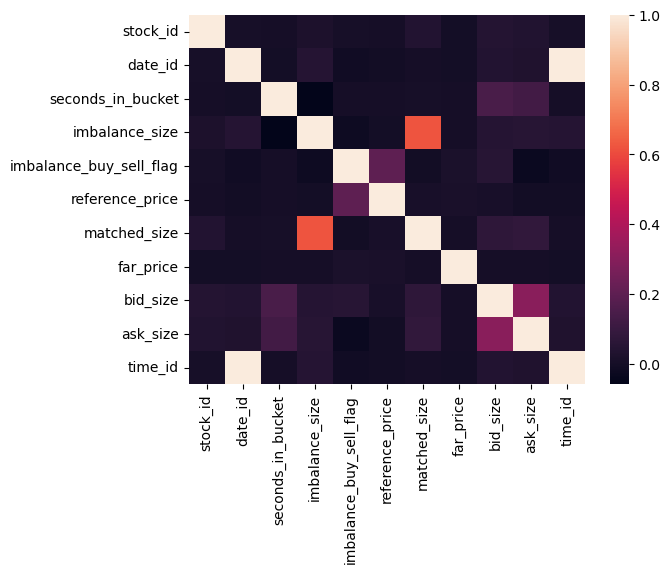

In [5]:
# isolating numerical values
num_vals = df.drop(["row_id"], axis=1)

# starting by removing NaN values from dataset
# we can try some more complex methods later on
num_vals = num_vals.dropna()

# creating heatmap
corr_plot = sns.heatmap(num_vals.corr())

In [33]:
num_vals.corr()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,bid_size,ask_size,time_id
stock_id,1.000000,0.005824,-0.000090,0.023061,0.004772,0.000348,0.036701,-0.000831,0.041245,0.034483,0.005824
date_id,0.005824,1.000000,-0.001001,0.045681,-0.010580,-0.007117,0.003408,-0.003004,0.038105,0.030655,1.000000
seconds_in_bucket,-0.000090,-0.001001,1.000000,-0.058611,0.002110,0.003402,0.003438,-0.000550,0.144290,0.125675,-0.000054
imbalance_size,0.023061,0.045681,-0.058611,1.000000,-0.020432,-0.002444,0.622069,0.000523,0.047609,0.049366,0.045625
imbalance_buy_sell_flag,0.004772,-0.010580,0.002110,-0.020432,1.000000,0.200544,-0.007488,0.018010,0.048959,-0.026707,-0.010578
reference_price,0.000348,-0.007117,0.003402,-0.002444,0.200544,1.000000,0.010638,0.015349,0.008795,-0.005956,-0.007114
matched_size,0.036701,0.003408,0.003438,0.622069,-0.007488,0.010638,1.000000,-0.000705,0.072581,0.078511,0.003411
far_price,-0.000831,-0.003004,-0.000550,0.000523,0.018010,0.015349,-0.000705,1.000000,0.002229,-0.000153,-0.003005
bid_size,0.041245,0.038105,0.144290,0.047609,0.048959,0.008795,0.072581,0.002229,1.000000,0.306011,0.038241
ask_size,0.034483,0.030655,0.125675,0.049366,-0.026707,-0.005956,0.078511,-0.000153,0.306011,1.000000,0.030774


In our plot, we noticed some high correlations betweeen:
- near price & reference price: 0.47
- imbalance_buy_sell_flag & reference price: 0.51
- imbalance size & matched size: 0.51

Looking at the correlation heatmap, it is very obvious that we need to do some feature selection on this data when constructing our models. Also, as expected, Target had no correlations with ANY of the features (otherwise there would be no Kaggle competition to begin with).

To begin with we create a simple linear model using the full feature space to act as our baseline

## Baseline Model

The respone is super tight around 1. Seems like we will need to normalize the data so that we can actually use it for our analysis

Text(0.5, 0, '$log_{10}(ref\\_price)$')

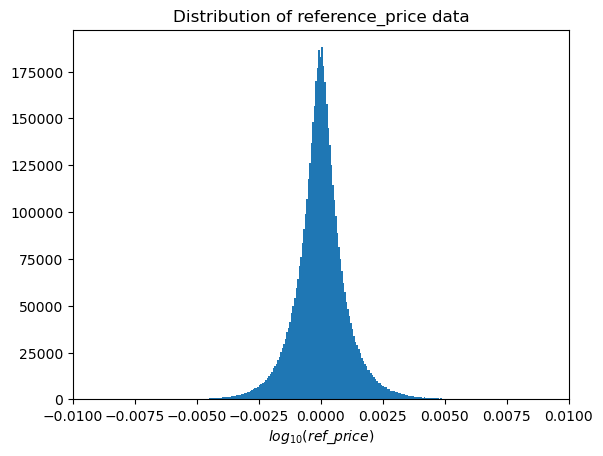

In [34]:
plt.hist(np.log10(df["reference_price"]),bins=1000)
plt.title("Distribution of reference_price data")
plt.xlim(-0.01,0.01)
plt.xlabel(r"$log_{10}(ref\_price)$")

In [6]:
# creating test-train split
X = num_vals.drop(["reference_price","imbalance_buy_sell_flag"], axis = 1)

y = num_vals["reference_price"]

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [51]:
# trying to normalize predictors
# went very poorly
y_tr_max = np.max(np.abs(y_tr))

y_tr_norm = y_tr/y_tr_max
y_tr_norm = np.reshape(y_tr_norm, [-1,1])

In [56]:
# creating model with fit
lmod = LinearRegression()
lmod.fit(X_tr,y_tr_norm)

LinearRegression()

In [55]:
# generating predictions
y_hat = lmod.predict(X_tst)

y_norm_tst = np.reshape(y_tst/y_tr_max,[-1,1])

# finding rmse of the baseline model
rmse_baseline = np.sqrt(mean_squared_error(y_norm_tst, y_hat))
print(rmse_baseline)

604.506207277218


c:\Users\elias\miniconda3\envs\data_sc\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [13]:
# creating feature selection model
bes = SequentialFeatureSelector(LinearRegression(), 
                                direction="forward")

# perfoming model fit
bes.fit(X_tr, y_tr)

# printing optimal feat
pred_bet_feature_set = bes.get_feature_names_out()
print(pred_bet_feature_set)

['seconds_in_bucket' 'imbalance_size' 'imbalance_buy_sell_flag'
 'near_price' 'bid_size']


In [14]:
X_tr_sub = X_tr[pred_bet_feature_set]
X_tst_sub = X_tst[pred_bet_feature_set]

sub_lmod = LinearRegression()

sub_lmod.fit(X_tr_sub,y_tr)

sub_lmod_preds = sub_lmod.predict(X_tst_sub)

# rmse with removed features
rmse_subset = np.sqrt(mean_squared_error(y_tst, sub_lmod_preds))
print(rmse_subset)

0.0026446263828093955


Looking at the RMSE we see above, it appears as though removing these features does not cause any form of increase in the RMSE. Although based on earlier correlation plots, it seems as though more features can be removed from the data.